# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

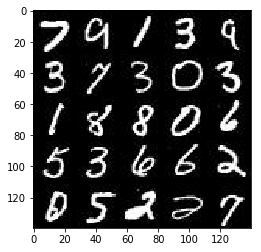

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

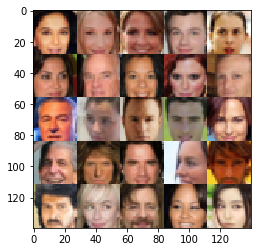

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='real_inputs')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (real_inputs, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.05
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*x3, x3)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha*x4, x4)
        
        x_reshaped = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(x_reshaped, 1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.05
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        
        x = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        output = tf.tanh(x4)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth=0.1
    
    g_output = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)*(1 - smooth)))
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    
    d_loss = d_real_loss + d_fake_loss
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_var = tf.trainable_variables()
    g_vars = [var for var in all_var if var.name.startswith('generator')]
    d_vars = [var for var in all_var if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #tf.reset_default_graph()
    
    print_every = 20
    step = 0
    show_every = 100
    n_images_to_show = 40
    
    #tf.reset_default_graph()
    
    real_inputs, z_data, ln_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_data, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = batch_images * 2
                
                z_input = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={
                        real_inputs:batch_images, z_data:z_input, ln_rate:learning_rate
                    })
                _ = sess.run(g_train_opt, feed_dict={
                        real_inputs:batch_images, z_data:z_input, ln_rate:learning_rate
                    })
                #_ = sess.run(g_train_opt, feed_dict={
                #        real_inputs:batch_images, z_data:z_input, ln_rate:learning_rate
                #     })
                
                if step % print_every == 0:
                    g_losses = g_loss.eval({z_data:z_input})
                    d_losses = d_loss.eval({real_inputs:batch_images, z_data:z_input})
                    print("Epoch: {}/{}".format(epoch_i, epoch_count),
                          "Batch: {}".format(step),
                         "Generator Loss: {}".format(g_losses),
                         "Discriminator Loss: {}".format(d_losses))
                    
                if step % show_every == 0:
                    show_generator_output(sess, n_images_to_show, z_data,
                                          data_shape[3], data_image_mode)
                
                
    return None
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0/1 Batch: 20 Generator Loss: 5.403360843658447 Discriminator Loss: 0.41479575634002686
Epoch: 0/1 Batch: 40 Generator Loss: 2.306412935256958 Discriminator Loss: 0.7689828276634216
Epoch: 0/1 Batch: 60 Generator Loss: 0.3555740714073181 Discriminator Loss: 1.8618830442428589
Epoch: 0/1 Batch: 80 Generator Loss: 2.733834743499756 Discriminator Loss: 0.518991231918335
Epoch: 0/1 Batch: 100 Generator Loss: 4.305099010467529 Discriminator Loss: 0.39700692892074585


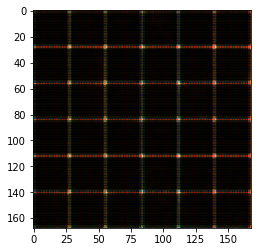

Epoch: 0/1 Batch: 120 Generator Loss: 0.3528442084789276 Discriminator Loss: 1.823925256729126
Epoch: 0/1 Batch: 140 Generator Loss: 1.2908177375793457 Discriminator Loss: 0.9742077589035034
Epoch: 0/1 Batch: 160 Generator Loss: 0.9847038984298706 Discriminator Loss: 1.1848443746566772
Epoch: 0/1 Batch: 180 Generator Loss: 2.391510009765625 Discriminator Loss: 1.2619738578796387
Epoch: 0/1 Batch: 200 Generator Loss: 0.4836551249027252 Discriminator Loss: 1.4908102750778198


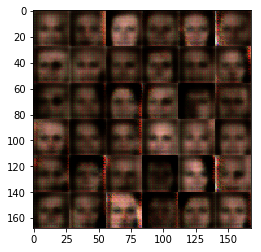

Epoch: 0/1 Batch: 220 Generator Loss: 0.6207303404808044 Discriminator Loss: 1.327776312828064
Epoch: 0/1 Batch: 240 Generator Loss: 0.8767455220222473 Discriminator Loss: 1.0030043125152588
Epoch: 0/1 Batch: 260 Generator Loss: 0.26763200759887695 Discriminator Loss: 1.8898612260818481
Epoch: 0/1 Batch: 280 Generator Loss: 1.755544900894165 Discriminator Loss: 1.2985361814498901
Epoch: 0/1 Batch: 300 Generator Loss: 1.726601481437683 Discriminator Loss: 1.2218246459960938


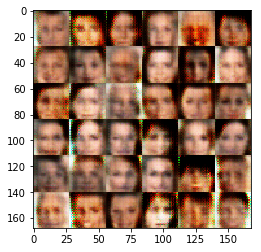

Epoch: 0/1 Batch: 320 Generator Loss: 0.22597983479499817 Discriminator Loss: 2.3034465312957764
Epoch: 0/1 Batch: 340 Generator Loss: 1.009093999862671 Discriminator Loss: 1.1630542278289795
Epoch: 0/1 Batch: 360 Generator Loss: 0.4319823086261749 Discriminator Loss: 1.5675586462020874
Epoch: 0/1 Batch: 380 Generator Loss: 0.7450489401817322 Discriminator Loss: 1.2364583015441895
Epoch: 0/1 Batch: 400 Generator Loss: 0.9497214555740356 Discriminator Loss: 1.1853299140930176


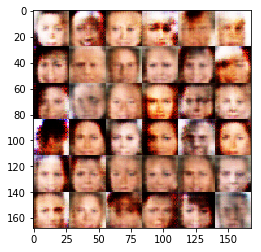

Epoch: 0/1 Batch: 420 Generator Loss: 0.7150518298149109 Discriminator Loss: 1.0780607461929321
Epoch: 0/1 Batch: 440 Generator Loss: 0.7080796957015991 Discriminator Loss: 1.4018774032592773
Epoch: 0/1 Batch: 460 Generator Loss: 0.4785926342010498 Discriminator Loss: 1.388028621673584
Epoch: 0/1 Batch: 480 Generator Loss: 1.0082244873046875 Discriminator Loss: 1.151860237121582
Epoch: 0/1 Batch: 500 Generator Loss: 0.7552600502967834 Discriminator Loss: 1.407313585281372


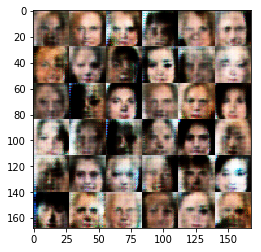

Epoch: 0/1 Batch: 520 Generator Loss: 2.1212189197540283 Discriminator Loss: 1.9937386512756348
Epoch: 0/1 Batch: 540 Generator Loss: 0.864387571811676 Discriminator Loss: 0.9676222205162048
Epoch: 0/1 Batch: 560 Generator Loss: 0.9144331216812134 Discriminator Loss: 1.0294569730758667
Epoch: 0/1 Batch: 580 Generator Loss: 1.160258173942566 Discriminator Loss: 1.2998924255371094
Epoch: 0/1 Batch: 600 Generator Loss: 0.5739741325378418 Discriminator Loss: 1.3572020530700684


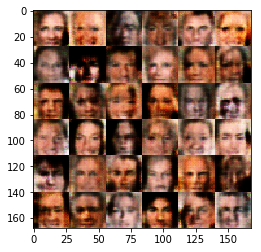

Epoch: 0/1 Batch: 620 Generator Loss: 0.9969462156295776 Discriminator Loss: 1.0415842533111572
Epoch: 0/1 Batch: 640 Generator Loss: 0.824425220489502 Discriminator Loss: 1.0089714527130127
Epoch: 0/1 Batch: 660 Generator Loss: 0.8289519548416138 Discriminator Loss: 1.3893643617630005
Epoch: 0/1 Batch: 680 Generator Loss: 1.0731418132781982 Discriminator Loss: 1.1165165901184082
Epoch: 0/1 Batch: 700 Generator Loss: 0.8698959350585938 Discriminator Loss: 1.3001106977462769


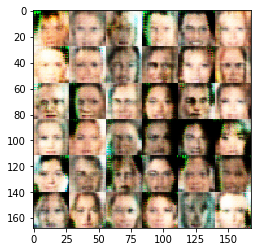

Epoch: 0/1 Batch: 720 Generator Loss: 1.0635619163513184 Discriminator Loss: 1.284677267074585
Epoch: 0/1 Batch: 740 Generator Loss: 0.8212029933929443 Discriminator Loss: 1.3020645380020142
Epoch: 0/1 Batch: 760 Generator Loss: 1.2068545818328857 Discriminator Loss: 1.0493078231811523
Epoch: 0/1 Batch: 780 Generator Loss: 1.5327080488204956 Discriminator Loss: 1.1609810590744019
Epoch: 0/1 Batch: 800 Generator Loss: 0.8254128694534302 Discriminator Loss: 1.285827875137329


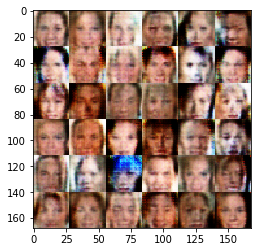

Epoch: 0/1 Batch: 820 Generator Loss: 0.9734363555908203 Discriminator Loss: 1.3931862115859985
Epoch: 0/1 Batch: 840 Generator Loss: 0.8262031674385071 Discriminator Loss: 0.9709154963493347
Epoch: 0/1 Batch: 860 Generator Loss: 1.6372795104980469 Discriminator Loss: 1.0870978832244873
Epoch: 0/1 Batch: 880 Generator Loss: 0.6299837827682495 Discriminator Loss: 1.3213739395141602
Epoch: 0/1 Batch: 900 Generator Loss: 0.9646113514900208 Discriminator Loss: 1.2434111833572388


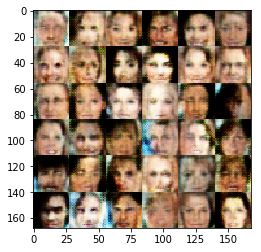

Epoch: 0/1 Batch: 920 Generator Loss: 1.664447546005249 Discriminator Loss: 1.1162110567092896
Epoch: 0/1 Batch: 940 Generator Loss: 1.179988980293274 Discriminator Loss: 0.8711917400360107
Epoch: 0/1 Batch: 960 Generator Loss: 1.6128904819488525 Discriminator Loss: 1.3850023746490479
Epoch: 0/1 Batch: 980 Generator Loss: 0.6038023233413696 Discriminator Loss: 1.2512929439544678
Epoch: 0/1 Batch: 1000 Generator Loss: 1.3354997634887695 Discriminator Loss: 0.9238315224647522


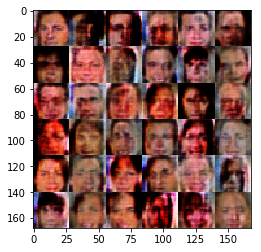

Epoch: 0/1 Batch: 1020 Generator Loss: 0.6807751655578613 Discriminator Loss: 1.253295660018921
Epoch: 0/1 Batch: 1040 Generator Loss: 1.034224271774292 Discriminator Loss: 0.9663354158401489
Epoch: 0/1 Batch: 1060 Generator Loss: 0.46011412143707275 Discriminator Loss: 1.4572834968566895
Epoch: 0/1 Batch: 1080 Generator Loss: 0.8223541975021362 Discriminator Loss: 1.0680327415466309
Epoch: 0/1 Batch: 1100 Generator Loss: 0.9411931037902832 Discriminator Loss: 1.2492822408676147


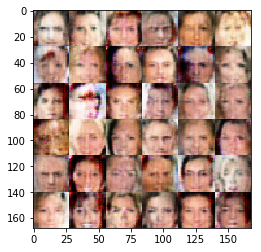

Epoch: 0/1 Batch: 1120 Generator Loss: 0.8969854116439819 Discriminator Loss: 1.1496518850326538
Epoch: 0/1 Batch: 1140 Generator Loss: 2.327376365661621 Discriminator Loss: 1.382246494293213
Epoch: 0/1 Batch: 1160 Generator Loss: 1.1100716590881348 Discriminator Loss: 1.1309458017349243
Epoch: 0/1 Batch: 1180 Generator Loss: 0.3150172829627991 Discriminator Loss: 1.8947018384933472
Epoch: 0/1 Batch: 1200 Generator Loss: 0.7068841457366943 Discriminator Loss: 1.1208086013793945


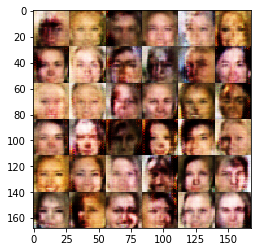

Epoch: 0/1 Batch: 1220 Generator Loss: 2.1943986415863037 Discriminator Loss: 1.4535571336746216
Epoch: 0/1 Batch: 1240 Generator Loss: 1.054710865020752 Discriminator Loss: 1.2134491205215454
Epoch: 0/1 Batch: 1260 Generator Loss: 0.8738998770713806 Discriminator Loss: 1.3000123500823975
Epoch: 0/1 Batch: 1280 Generator Loss: 1.0543630123138428 Discriminator Loss: 1.2827225923538208
Epoch: 0/1 Batch: 1300 Generator Loss: 0.6907070279121399 Discriminator Loss: 1.2034924030303955


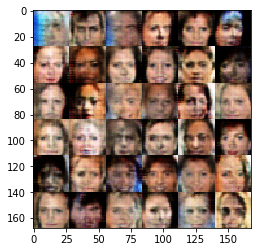

Epoch: 0/1 Batch: 1320 Generator Loss: 1.2026031017303467 Discriminator Loss: 0.9737436771392822
Epoch: 0/1 Batch: 1340 Generator Loss: 1.3493810892105103 Discriminator Loss: 0.8422835469245911
Epoch: 0/1 Batch: 1360 Generator Loss: 1.3952056169509888 Discriminator Loss: 1.2011476755142212
Epoch: 0/1 Batch: 1380 Generator Loss: 1.20826256275177 Discriminator Loss: 1.2339342832565308
Epoch: 0/1 Batch: 1400 Generator Loss: 0.9541573524475098 Discriminator Loss: 1.1807332038879395


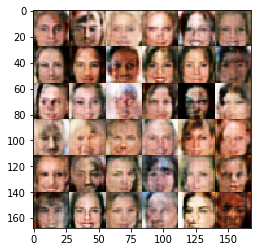

Epoch: 0/1 Batch: 1420 Generator Loss: 1.6066863536834717 Discriminator Loss: 1.1156085729599
Epoch: 0/1 Batch: 1440 Generator Loss: 0.608494758605957 Discriminator Loss: 1.3324483633041382
Epoch: 0/1 Batch: 1460 Generator Loss: 0.9979406595230103 Discriminator Loss: 1.062563419342041
Epoch: 0/1 Batch: 1480 Generator Loss: 1.0711870193481445 Discriminator Loss: 1.2071443796157837
Epoch: 0/1 Batch: 1500 Generator Loss: 0.9422434568405151 Discriminator Loss: 1.2017502784729004


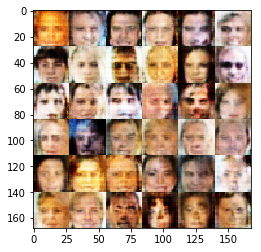

Epoch: 0/1 Batch: 1520 Generator Loss: 0.9150379300117493 Discriminator Loss: 1.0127373933792114
Epoch: 0/1 Batch: 1540 Generator Loss: 0.785140872001648 Discriminator Loss: 1.2555153369903564
Epoch: 0/1 Batch: 1560 Generator Loss: 1.0060651302337646 Discriminator Loss: 1.144099235534668
Epoch: 0/1 Batch: 1580 Generator Loss: 0.790379524230957 Discriminator Loss: 1.1327141523361206
Epoch: 0/1 Batch: 1600 Generator Loss: 0.7884683609008789 Discriminator Loss: 1.0682965517044067


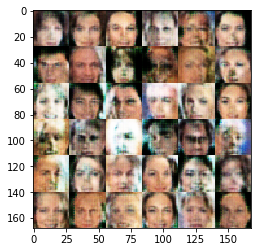

Epoch: 0/1 Batch: 1620 Generator Loss: 0.9471524357795715 Discriminator Loss: 1.2384487390518188
Epoch: 0/1 Batch: 1640 Generator Loss: 0.6530560851097107 Discriminator Loss: 1.3634862899780273
Epoch: 0/1 Batch: 1660 Generator Loss: 0.7935618162155151 Discriminator Loss: 1.1247398853302002
Epoch: 0/1 Batch: 1680 Generator Loss: 0.9025413393974304 Discriminator Loss: 0.9642367362976074
Epoch: 0/1 Batch: 1700 Generator Loss: 0.816466748714447 Discriminator Loss: 1.1594887971878052


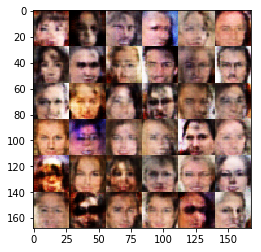

Epoch: 0/1 Batch: 1720 Generator Loss: 0.6678224802017212 Discriminator Loss: 1.292604684829712
Epoch: 0/1 Batch: 1740 Generator Loss: 0.6204441785812378 Discriminator Loss: 1.3170866966247559
Epoch: 0/1 Batch: 1760 Generator Loss: 0.7475561499595642 Discriminator Loss: 1.174156904220581
Epoch: 0/1 Batch: 1780 Generator Loss: 0.6094733476638794 Discriminator Loss: 1.3855445384979248
Epoch: 0/1 Batch: 1800 Generator Loss: 0.8330663442611694 Discriminator Loss: 1.2085862159729004


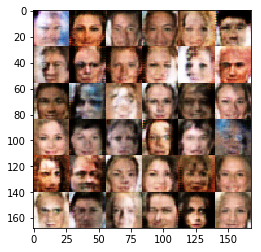

Epoch: 0/1 Batch: 1820 Generator Loss: 0.7433682680130005 Discriminator Loss: 1.2487173080444336
Epoch: 0/1 Batch: 1840 Generator Loss: 1.1182928085327148 Discriminator Loss: 1.443590521812439
Epoch: 0/1 Batch: 1860 Generator Loss: 0.7153869271278381 Discriminator Loss: 1.4057451486587524
Epoch: 0/1 Batch: 1880 Generator Loss: 0.6252149343490601 Discriminator Loss: 1.1999634504318237
Epoch: 0/1 Batch: 1900 Generator Loss: 0.7721958160400391 Discriminator Loss: 1.2919272184371948


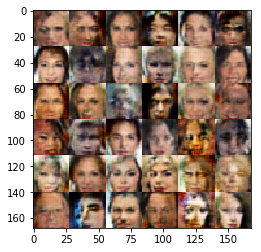

Epoch: 0/1 Batch: 1920 Generator Loss: 0.8600860834121704 Discriminator Loss: 1.2496931552886963
Epoch: 0/1 Batch: 1940 Generator Loss: 0.8940455913543701 Discriminator Loss: 1.234080195426941
Epoch: 0/1 Batch: 1960 Generator Loss: 0.8340291976928711 Discriminator Loss: 1.1625759601593018
Epoch: 0/1 Batch: 1980 Generator Loss: 0.7265520095825195 Discriminator Loss: 1.30332350730896
Epoch: 0/1 Batch: 2000 Generator Loss: 0.5930218696594238 Discriminator Loss: 1.268762469291687


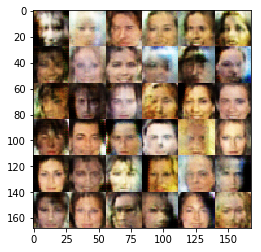

Epoch: 0/1 Batch: 2020 Generator Loss: 0.9522798657417297 Discriminator Loss: 1.0310921669006348
Epoch: 0/1 Batch: 2040 Generator Loss: 1.271850347518921 Discriminator Loss: 1.239370584487915
Epoch: 0/1 Batch: 2060 Generator Loss: 0.8779990077018738 Discriminator Loss: 1.3873635530471802
Epoch: 0/1 Batch: 2080 Generator Loss: 0.5313810110092163 Discriminator Loss: 1.3652708530426025
Epoch: 0/1 Batch: 2100 Generator Loss: 1.471536636352539 Discriminator Loss: 1.3891220092773438


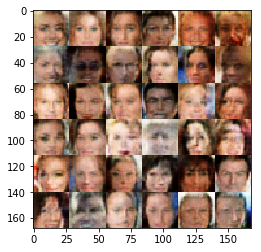

Epoch: 0/1 Batch: 2120 Generator Loss: 1.0103768110275269 Discriminator Loss: 1.2325279712677002
Epoch: 0/1 Batch: 2140 Generator Loss: 1.1595571041107178 Discriminator Loss: 1.076932668685913
Epoch: 0/1 Batch: 2160 Generator Loss: 0.7074658870697021 Discriminator Loss: 1.2368398904800415
Epoch: 0/1 Batch: 2180 Generator Loss: 1.450859546661377 Discriminator Loss: 0.9825103282928467
Epoch: 0/1 Batch: 2200 Generator Loss: 0.9364688396453857 Discriminator Loss: 1.045965313911438


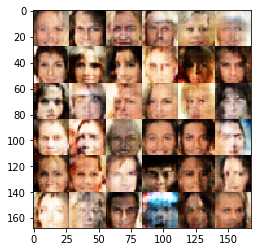

Epoch: 0/1 Batch: 2220 Generator Loss: 0.8494150638580322 Discriminator Loss: 1.3399322032928467
Epoch: 0/1 Batch: 2240 Generator Loss: 0.8894653916358948 Discriminator Loss: 1.254038691520691
Epoch: 0/1 Batch: 2260 Generator Loss: 0.8379973769187927 Discriminator Loss: 1.1008484363555908
Epoch: 0/1 Batch: 2280 Generator Loss: 0.9545574188232422 Discriminator Loss: 1.3858665227890015
Epoch: 0/1 Batch: 2300 Generator Loss: 0.8903440237045288 Discriminator Loss: 1.0842323303222656


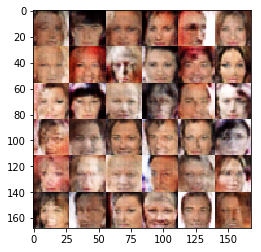

Epoch: 0/1 Batch: 2320 Generator Loss: 1.3736680746078491 Discriminator Loss: 1.3596092462539673
Epoch: 0/1 Batch: 2340 Generator Loss: 1.1838650703430176 Discriminator Loss: 1.5091054439544678
Epoch: 0/1 Batch: 2360 Generator Loss: 0.7975205183029175 Discriminator Loss: 1.3231728076934814
Epoch: 0/1 Batch: 2380 Generator Loss: 1.0852141380310059 Discriminator Loss: 1.1448804140090942
Epoch: 0/1 Batch: 2400 Generator Loss: 0.6890424489974976 Discriminator Loss: 1.1801139116287231


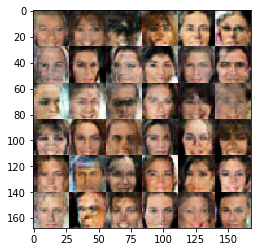

Epoch: 0/1 Batch: 2420 Generator Loss: 0.8477731943130493 Discriminator Loss: 1.0869653224945068
Epoch: 0/1 Batch: 2440 Generator Loss: 0.8352288007736206 Discriminator Loss: 1.1724624633789062
Epoch: 0/1 Batch: 2460 Generator Loss: 0.8991514444351196 Discriminator Loss: 1.0187877416610718
Epoch: 0/1 Batch: 2480 Generator Loss: 0.8536858558654785 Discriminator Loss: 1.224300503730774
Epoch: 0/1 Batch: 2500 Generator Loss: 0.9778921008110046 Discriminator Loss: 1.3105084896087646


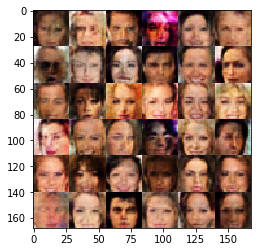

Epoch: 0/1 Batch: 2520 Generator Loss: 0.7762113809585571 Discriminator Loss: 1.1330146789550781
Epoch: 0/1 Batch: 2540 Generator Loss: 1.1074373722076416 Discriminator Loss: 1.0808322429656982
Epoch: 0/1 Batch: 2560 Generator Loss: 1.1304607391357422 Discriminator Loss: 1.276731252670288
Epoch: 0/1 Batch: 2580 Generator Loss: 0.8942642211914062 Discriminator Loss: 1.1806844472885132
Epoch: 0/1 Batch: 2600 Generator Loss: 0.9578888416290283 Discriminator Loss: 1.272659182548523


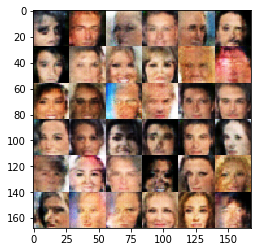

Epoch: 0/1 Batch: 2620 Generator Loss: 1.3081332445144653 Discriminator Loss: 1.5650560855865479
Epoch: 0/1 Batch: 2640 Generator Loss: 0.7312542200088501 Discriminator Loss: 1.33175528049469
Epoch: 0/1 Batch: 2660 Generator Loss: 0.7357388734817505 Discriminator Loss: 1.0954179763793945
Epoch: 0/1 Batch: 2680 Generator Loss: 0.6270737051963806 Discriminator Loss: 1.504550814628601
Epoch: 0/1 Batch: 2700 Generator Loss: 0.6954085826873779 Discriminator Loss: 1.3668934106826782


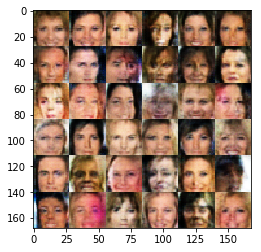

Epoch: 0/1 Batch: 2720 Generator Loss: 1.192429542541504 Discriminator Loss: 1.272566795349121
Epoch: 0/1 Batch: 2740 Generator Loss: 1.0656037330627441 Discriminator Loss: 1.0563950538635254
Epoch: 0/1 Batch: 2760 Generator Loss: 0.8904610276222229 Discriminator Loss: 1.1394720077514648
Epoch: 0/1 Batch: 2780 Generator Loss: 0.9443676471710205 Discriminator Loss: 1.252273440361023
Epoch: 0/1 Batch: 2800 Generator Loss: 0.7373472452163696 Discriminator Loss: 1.2527506351470947


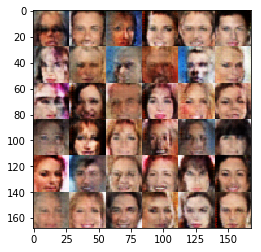

Epoch: 0/1 Batch: 2820 Generator Loss: 0.8042300939559937 Discriminator Loss: 1.2429015636444092
Epoch: 0/1 Batch: 2840 Generator Loss: 0.760055422782898 Discriminator Loss: 1.1890604496002197
Epoch: 0/1 Batch: 2860 Generator Loss: 0.6758818626403809 Discriminator Loss: 1.2576384544372559
Epoch: 0/1 Batch: 2880 Generator Loss: 0.33764785528182983 Discriminator Loss: 1.7581532001495361
Epoch: 0/1 Batch: 2900 Generator Loss: 0.5803061127662659 Discriminator Loss: 1.4940122365951538


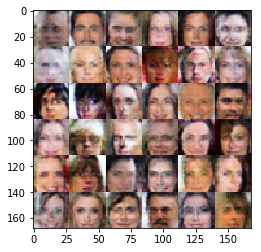

Epoch: 0/1 Batch: 2920 Generator Loss: 1.1037569046020508 Discriminator Loss: 1.1240413188934326
Epoch: 0/1 Batch: 2940 Generator Loss: 0.8969042301177979 Discriminator Loss: 1.2987654209136963
Epoch: 0/1 Batch: 2960 Generator Loss: 0.676039457321167 Discriminator Loss: 1.3324553966522217
Epoch: 0/1 Batch: 2980 Generator Loss: 0.905245304107666 Discriminator Loss: 1.2654056549072266
Epoch: 0/1 Batch: 3000 Generator Loss: 0.6851133108139038 Discriminator Loss: 1.2950053215026855


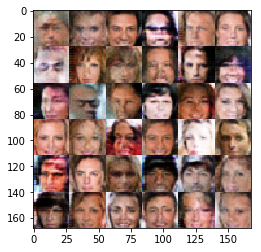

Epoch: 0/1 Batch: 3020 Generator Loss: 0.5804543495178223 Discriminator Loss: 1.315597414970398
Epoch: 0/1 Batch: 3040 Generator Loss: 0.7977287173271179 Discriminator Loss: 1.3480517864227295
Epoch: 0/1 Batch: 3060 Generator Loss: 0.8557996153831482 Discriminator Loss: 1.229296088218689
Epoch: 0/1 Batch: 3080 Generator Loss: 0.8317983150482178 Discriminator Loss: 1.1801979541778564
Epoch: 0/1 Batch: 3100 Generator Loss: 0.7780715227127075 Discriminator Loss: 1.2989654541015625


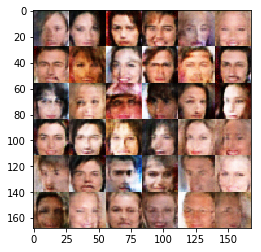

Epoch: 0/1 Batch: 3120 Generator Loss: 1.1853454113006592 Discriminator Loss: 1.1996196508407593
Epoch: 0/1 Batch: 3140 Generator Loss: 0.7993198037147522 Discriminator Loss: 1.1738529205322266
Epoch: 0/1 Batch: 3160 Generator Loss: 0.8369881510734558 Discriminator Loss: 1.120919108390808


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.